In [4]:
import numpy as np
import pylab as plt
import time

In [5]:
def load_data(fname_spike_train, update_tmax=True):
    """Load data."""
    data = np.load(fname_spike_train, allow_pickle=1)
    # convert to list of spike trains
    spk_trains = []
    id_ch_unique = np.unique(data[0, :])
    for id_ch in id_ch_unique:
        idx = np.where(data[0, :] == id_ch)[0]
        spk_trains.append(data[1, idx])
    tmax = np.max(data[1, idx])
    if update_tmax:
        params['tmax'] = tmax
    # id_ch_unique: id <-> (row, column) spatial coordinatesa
    return spk_trains, id_ch_unique, tmax

def format_spike_train(spk_trains):
    """Format spike trains.

    spk_trains  a list of spike trains
    """
    idx_spk_tr, len_spk_tr = [], []
    for spk_train in spk_trains:
        spk_train_arr = np.array(spk_train)
        idx_spk_train = (spk_train_arr/params['dt']).astype(int)
        len_spk_tr.append(len(idx_spk_train))
        idx_spk_tr.append(idx_spk_train)
    return idx_spk_tr, len_spk_tr


In [6]:
params = {'dt': 0.5, 'tw': 5, 'tmax': 6e5, 'corr': True}

In [7]:
# get the data from the web ... 
import os

if not(os.path.isdir('data')):
    print("Folder <<data>> created!")
    os.makedirs('data')
if not(os.path.isfile('data/data.npy')):
    print("Transfer data.npy!")
    str_get = "https://unimi2013-my.sharepoint.com/:u:/g/personal/thierry_nieus_unimi_it/EYxkNBwY_LNNvaYMNoYQMOMBm0EBC-hHMdMMs23KfSVTLg?e=NHjjXA&download=1"
    wget = "os.system"
    os.system("wget --no-check-certificate \"%s\" -q -O data/data.npy" % str_get)
fn = 'data/data.npy'

Folder <<data>> created!
Transfer data.npy!


In [8]:
spk_trains_tmp, id_ch_tmp, tmax = load_data(fn)
tmax /= 1000 # tmax in seconds
print('%d spike trains loaded ' % len(spk_trains_tmp))
print('max time of recording (s) %g ' %tmax)

793 spike trains loaded 
max time of recording (s) 565.398 


In [9]:
mfr_min = 0.1 # Hz
spk_trains, id_ch = [], []
mfr_lst = []
for st, ic in zip(spk_trains_tmp, id_ch_tmp):
    mfr = len(st) / tmax  # Hz    
    if mfr > mfr_min:
        # spike train has enough spikes
        spk_trains.append(st)
        id_ch.append(ic)
        mfr_lst.append(mfr)
print('%d spike trains retained ' % len(spk_trains)) 

793 spike trains retained 


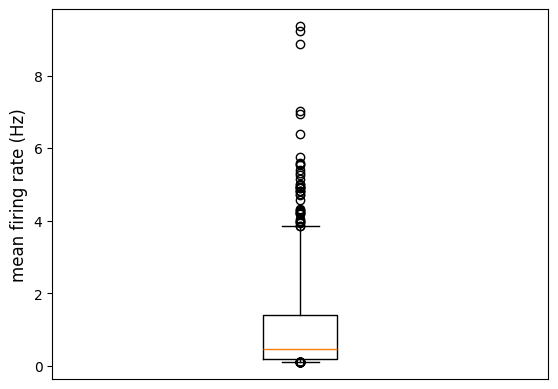

In [10]:
plt.boxplot(mfr_lst, whis=[5, 95])
plt.xticks([])
plt.ylabel('mean firing rate (Hz)', fontsize=12);

In [11]:
idx_spk_tr, len_spk_tr = format_spike_train(spk_trains)

In [12]:
from scipy.sparse import csr_matrix
timo = time.time()
max_idx = np.max([np.max(i) for i in idx_spk_tr])
num_trains = len(idx_spk_tr)
nstep = int(params['tw'] / params['dt'])
delayd = csr_matrix((len(idx_spk_tr),max_idx+2*nstep+1))
ccmat= np.zeros((nstep*2+1,num_trains,num_trains))
for i in range(num_trains):
    delayd[i,(idx_spk_tr[i]-1+nstep)]=1
ref = delayd[:,nstep:-(nstep+1)]

sizes = np.array(len_spk_tr)
sizes = sizes.reshape(len(sizes), 1)
lijs = sizes.dot(sizes.T)
lijs_sc = (lijs/params['tmax'])*params['dt']
for k in range(nstep*2+1): 
    ccmat_ = ref.dot(delayd[:,k:(max_idx+k)].T)
    #sizes = ccmat.sum(axis=0).T
    ccmat_ -= lijs_sc
    ccmat_ /=  np.sqrt(lijs)
    ccmat[k] = ccmat_
print(ccmat.shape)
print((time.time()-timo))

/Users/federico/miniconda3/envs/cobra_fede/lib/python3.10/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


(21, 793, 793)
1.1695828437805176


In [13]:
tcc = np.arange(-params['tw'], params['tw'] + params['dt'], params['dt'])
idx_sd = []
idx = np.triu_indices(num_trains, 1)
for idx_src, idx_dst in zip(*idx):
    idx_sd.append((idx_src, idx_dst))

In [14]:
cc_lst = []
for k in idx_sd:
    i,j  = k
    cc_lst.append(ccmat[:,i,j])

In [15]:
# Define some useful functions
def get_row_col(id_ch):
    """Return row and column of channel id_ch."""
    row = id_ch // 64
    col = id_ch % 64    
    return row, col

def chan_dist(rc_src, rc_dst):
    """Compute distance between two channels/electrodes."""
    pitch = 80 # um
    d2 = (rc_src[0] - rc_dst[0])**2 + (rc_src[1] - rc_dst[1])**2
    d = np.sqrt(d2) * pitch
    return d

In [16]:
dout = {}
keys = ['cc-peak', 'cc-peak-time-lag (ms)', 'distance (um)', 'velocity (mm/s)']
for key in keys:
    dout[key] = []

for k, cc in enumerate(cc_lst):
    # cc-max
    cc_max = np.max(cc)
    idx_max = np.argmax(cc)
    t_peak = tcc[idx_max]
    # distance
    idx_src, idx_dst = idx_sd[k]
    rc_src = get_row_col(id_ch[idx_src])
    rc_dst = get_row_col(id_ch[idx_dst])
    dist = chan_dist(rc_src, rc_dst)
    # velocity
    if t_peak:
        vel = dist / t_peak  # um / ms = mm/s
    else:
        vel = 1e10
    # store results
    dout['cc-peak'].append(cc_max)
    dout['cc-peak-time-lag (ms)'].append(t_peak)
    dout['distance (um)'].append(dist)
    dout['velocity (mm/s)'].append(abs(vel))

In [17]:
# define data frame and rank it based on the spike cross-correlation values (from highest to lowest)
import pandas as pd
df = pd.DataFrame(dout)
df.sort_values('cc-peak', ascending=False, inplace=True)
df.head(n=20)

/var/folders/q5/056kb3vd0nvgn53dnjdyb5d00000gn/T/ipykernel_24245/26055952.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


,cc-peak,cc-peak-time-lag (ms),distance (um),velocity (mm/s)
83193,0.393650,0.0,80.000000,1.000000e+10
303443,0.392940,0.5,80.000000,1.600000e+02
130770,0.233888,1.5,252.982213,1.686548e+02
139738,0.232774,-0.5,288.444102,5.768882e+02
202417,0.134919,0.0,80.000000,1.000000e+10
44307,0.133154,0.5,288.444102,5.768882e+02
84551,0.132141,-2.5,4882.622246,1.953049e+03
202889,0.126756,0.0,80.000000,1.000000e+10
233440,0.124302,0.0,80.000000,1.000000e+10
151876,0.123927,0.0,80.000000,1.000000e+10
